**More Practical Methods To Reduce Privacy Loss When Disclosing Statistics Based On Microdata**

**0. Abstract** *(:30)*

We replicate a simple method by Chetty and Friedman (2019) to reduce privacy loss when disclosing regression estimates.

The paper we replicate focusses on small samples; however, we show that for small samples researchers are better off using Robust methods.

The extension of research aims to create a practical method to attain provably Differentially Private regression estimates.

Algorithms we test are as follows:
 - Algorithm A: Chetty & Friedman (2019) Algorithm
  - For OLS
  - Modified for ad-hoc MM-Estimation
  - Comparison with Koller & Stahel (2014) "SMDM"-Estimation
 
 - Algortihm B: Dwork & Lei (2009) Algorithm
  - The problem with OLS in DP
  - Comparing ad-hoc MM against SDMD
 
 - Comparison with existing algorithms: *[WIP]*
  - A.Smith's (2011) Widened Winsorized Mean - for large samples
  - B.Rubenstein (2017) The Bernstein mechanism - Melbourne University

**1. The Problem** *(:30)*

U.S. Census Microdata:
 - Dinur and Nissim (2003) 
  - Database Reconstruction Attack 
 - Garfinkel et al. (2018); defending against a DRA:
  - Publish less data
  - Apply noise before tabulation
  - Apply noise to the published statistics
  
 - Without a privacy-protection system based on noise injection, it would be feasible to reconstruct accurate microdata using only the published statistics

**2. Diclosure Avoidance Methods**
*(1:30)*

**Statatistical Disclosure Limitation (SDL)**

The SDL framework for protecting against identity 

Exsting Methods:
- [for] Continuous Variables:
 - Adding Noise
 - Microaggregation
 - Shuffling (data swapping)
- [for] Categorical Variables:
 - Recoding & Local Suppression (omitting data)

**Differential Privacy**

**Definition 1.**

 - a randomised function $\mathcal{K}$ gives $(\epsilon,\delta)$-*differential privacy* if for all data sets $D$ and $D'$ differing on at most one element, and all $S\subset \text{Range}\left(\mathcal{K}\right)$;

$$\mathbb{P}\left[\mathcal{K}\left( D \right)\in S\right] 
\le e^{\epsilon} \cdot \mathbb{P}
\left[\mathcal{K}\left( D' \right) \in S \right] + \delta
$$

 - Differential Privacy compares the risk of an individual/group when included in, versus when not included in, the database.
 - privacy comes from uncertainty, and differentially private mechanisms provide that uncertainty by adding an amount of noise 
  - similar in spirit to randomized response
 - the parameter $\epsilon$ is a policy question; often thought of as $\in(0,1)$

Ultimately we aim to obtain $(\epsilon,\delta)$-*differential privacy* whilst preserving the accuracy and usefulness of the statistic

**3. Challenges**

The key technical challenge is determining the sensitivity of the regression estimates. 

**Definition 2.**

For $f:\mathcal{D}\to\mathbb{R}^d$, the *sensitivity* of $f$ is;

$$\Delta f = \max_{D, D'}\lVert f(D) - f(D')\rVert_1$$

The most common approach is to measure the *global* sensitivity of the statistic by computing the maximum amount a regression estimate could change when a single observatiom is added for *any possible realisation of the data*
- The problem however is that for standard regression methods, the sensitivity is infinite

However, one can compute the *local sensitivity* looks at the changes for any given sample.
- The problem however is that releasing the local sensitivity may *itself* divulge private information.

**4. Chetty & Friedman (2019)**

They compute the local sensitivity in each cell (e.g. each Census tract) and then define the *maximum observed sensitivity* (MOS), adjusting for differences in cell sample sizes

They then add noise proportional to the MOS

** 5. Implementation **

In [3]:
# Local Import
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
import numpy.linalg as la
from itertools import product
import numpy.random as nr

# Plot Tools
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import cycler
colors = cycler('color', 
       ['#EE6666', '#3388BB', '#9988DD', '#EECC55', 
       '#88BB44', '#FFBBBB'])

plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
      axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

# R in Python Interface
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
robustbase = importr('robustbase')
base = importr('base')
utils = importr('utils')

In [16]:
# Test Data - Census Tract
%cd '/home/nbuser/library/example_code_implementation_guide/'
stata = pd.read_stata('private_data_by_cells.dta')
data = stata[stata.columns[::-1]]

# 1. Data Wrangle - Pandas to Numpy
class Wrangle:
    '''
    Data Wrangling Class'''
    
    def __init__(self, data, partition=None):
        # Numpy-nize Census Tract
        self.Key = data.keys()
        Cell = np.unique(np.array(data[self.Key[0]])).astype(int)    
        Y = [np.array(data.loc[data.loc[:, self.Key[0]]== i, self.Key[1]]) for i in Cell]
        if len(self.Key) > 3:
            None
        else:
            X = [np.array(data.loc[data.loc[:, self.Key[0]]== i, self.Key[2]]) for i in Cell]
        
        # optional partitioning
        if partition is not None:
            pX = [np.array_split(i, 2) for i in X]
            pY = [np.array_split(i, 2) for i in Y]
            if partition==1:
                X = np.transpose(pX)[0]
                Y = np.transpose(pY)[0]
            elif partition==2:
                X = np.transpose(pX)[1]
                Y = np.transpose(pY)[1]

        self.X = X
        self.Y = Y 
        self.N = np.array([len(i) for i in X])
        self.Cells = len(self.N) 

class Alg_1:
    '''
    Chetty and Friedman Algorithm 
    '''
    def __init__(self, data, method, figure=[], ϵ=4.0, partition=None):
        ''' Setup selves '''
        self.D = Wrangle(data, partition=partition)
        self.col = len(self.D.Key) - 1
        self.Outlier = np.array([list(i) for i in product([0, 1], repeat = self.col)])
        self.figure = figure
        self.method = method
        self.ϵ = ϵ
        self.nd75 = ss.norm.ppf(0.75)
        self.W = np.array([1])
        self.N = self.D.N
        self.index = range(self.D.Cells)
        self.range = range(4) 
        if self.method == "LmRob":
            self.form = ro.Formula("y~x")
    
    def ω(self):
        ''' 
        Draw from Laplace Distribution 
        '''
#         if self.method=="OLS":
#             return nr.laplace(0, 1/math.sqrt(2))
#         else:
#             return nr.laplace(0, 1/ϵ)
        return nr.laplace(0, 1/math.sqrt(2))
    
    def r(self, x):
         return range(len(x))
    
    def lsR(self, I, O=None):
        ''' 
        Sort Arrays for Outlier Variations
        '''
        if O is None:
            y = np.asarray(self.D.Y[I]) 
            x = np.asarray(self.D.X[I])
        else:
            y = np.block([self.D.Y[I], self.Outlier[O][0]])
            x = np.block([self.D.X[I], self.Outlier[O][1]])

        return x, y

    def stack(self, x):
        add = np.ones(len(x))
        return np.block([[add], [x.T]]).T
    
    def lstsq(self, x, y, stderr=False, w=None):
        '''
        Calculus Linear Least Squares Optimisation via Numpy
        '''
        # Compare to Weight in LSTSQ
        x = self.stack(x)
        if w is not None:
            XX = x.T.dot(np.diag(w)).T
        else:
            XX = x
            
        betas = np.dot(la.inv(XX.T.dot(x)), XX.T.dot(y))
        ϵ = y - np.dot(XX, betas)
        if stderr:
            if len(y) > 5:
                stderr = np.sqrt(ϵ.dot(ϵ) / np.sum(np.square(XX.T[1] - np.mean(XX.T[1]))) / (len(ϵ) - self.col))
            else:
                stderr = np.inf
        return betas, ϵ, stderr
    
    def MAD(self, ϵ):
        return np.median(np.absolute(ϵ - np.median(ϵ)))
    
    def Tukey(self, u, c=1.547):
        ρ = np.power(u, 2) / 2 - np.power(u, 4) / (2 * math.pow(c, 2)) + np.power(u, 6) / (6 * math.pow(c, 4))
        if np.any(np.abs(u) > c):
            ρ[np.abs(u) > c] = math.pow(c, 2) / 6
            
        return ρ
            
    def Scale(self, ϵ, w=None, K=0.199):
        ''' 
        Scale calculation for S-Estimator part of MM
        '''
        if w is None:
            σ = self.MAD(ϵ) / self.nd75 
        else:
            σ = np.sqrt(np.sum(np.multiply(np.square(ϵ),w)) / (len(ϵ) * K))
        
        return σ
    
    def U(self, ϵ, σ):
        return ϵ / σ
    
    def weight(self, u, method="S", it=False):
        if method=="S":
            if not it:
            # iteration = 1
                W = np.square(u / 1.547)
                if np.any(np.abs(u) > 1.547):
                    W[np.abs(u) > 1.547] = 0
                weight = np.square(1 - W)
            else:
                weight = self.Tukey(u) / np.square(u)
        if method=="MM":
            W = np.square(u / 4.685)
            if np.any(np.abs(u) > 4.685):
                W[np.abs(u) > 4.685] = 0
            weight = np.square(1 - W)
        
        return weight
    
    def OLS(self, I, O=None, stderr=False):
        # for bug testing
        R01, R02 = self.lsR(I=I, O=O)
        R, ϵ, boo = self.lstsq(R01, R02)
        return R, ϵ, boo
    
    def MM(self, I, O=None, stderr=False):
        ''' 
        MM - Estimator Regression Algorithm as specificied in S 2009
        '''
        # 1. Ordinary Least Squares
        R01, R02 = self.lsR(I=I, O=O)
        RO1, ϵ, boo = self.lstsq(R01, R02)
        beta = RO1
        # 2. S-Estimate Convergence
        σ = self.Scale(ϵ)
        U = self.U(ϵ, σ)
        W = self.weight(U, "S", False)
        S, ϵ, boo = self.lstsq(R01, R02, w=W)
        # Convergence Loop
        maxiter = 100
        for i in range(maxiter):
            σ = self.Scale(ϵ, w=W)
            U = self.U(ϵ, σ)
            W = self.weight(U, "S", True)
            S, ϵ, boo = self.lstsq(R01, R02, w=W)
            if np.allclose(S, beta, rtol=1e-09):
                break
            else:
                beta = S
        # use residuals and scale of S-estimate
        # 3. MM-Estimate Convergence
        σ = self.Scale(ϵ)
        for i in range(maxiter):
            U = self.U(ϵ, σ)
            W = self.weight(U, "MM")
            M, ϵ, boo = self.lstsq(R01, R02, w=W)
            if np.allclose(M, beta, rtol=1e-03):
                break
            else:
                beta = M
#                 print(M)

        if stderr:
            RW1, RW2, boo = self.lstsq(R01, R02, True, w=W)
        
        # return betas, residuals, stderr, scale
        return M, ϵ, boo, σ
    
    def lmrob(self, x, y):
        '''
        Run M-Estimator Robust Regression in R via rpy2
        '''
        # clear R workspace for looping
        #base.rm(list='ls()')
        # Set up formula environment
        self.form.environment["y"] = ro.r['matrix'](ro.FloatVector(y.flatten()), ncol=1)
        self.form.environment["x"] = ro.r['matrix'](ro.FloatVector(x.flatten()), ncol=1)
        # Run Robust Regression
        lmr = robustbase.lmrob(self.form, method = "SMDM", setting="KS2014")
        # must copy variables because of memory constraint
        betas = np.array(lmr.rx2("coefficients"), copy=True)
        scale = np.array(lmr.rx2("scale"), copy=True)
        residuals = np.array(lmr.rx2("residuals"), copy=True)
        stderr = np.array(lmr.rx2("cov"), copy=True)[0][0]
        return betas, residuals, stderr, scale
    
    def oR(self, bool=False):
        '''
        Specify regression method and run all regression in one/two line(s)
        '''
        if self.method == "OLS":
            R0 = np.asarray([self.lsR(i) for i in self.index])
            self.RA = np.asarray([self.lstsq(i[0], i[1], True) for i in R0])
            R1 = np.asarray([[self.lsR(i, O=j) for j in self.range] for i in self.index])
            self.RB = np.asarray([[self.lstsq(i[j][0], i[j][1]) for j in self.range] for i in R1] )           
        elif self.method == "MM":
            self.RA = np.asarray([self.MM(i, stderr=True) for i in self.index])
            self.RB = np.asarray([[self.MM(i, j) for j in self.range] for i in self.index])
        elif self.method == "LmRob":
            R0 = np.asarray([self.lsR(i) for i in self.index])
            self.RA = np.asarray([self.lmrob(i[0], i[1]) for i in R0])
            R1 = np.asarray([[self.lsR(i, O=j) for j in self.range] for i in self.index])
            self.RB = np.asarray([[self.lmrob(i[j][0], i[j][1]) for j in self.range] for i in R1])          
            
        if bool:
            return self.RA.T[0], self.RB.T[0]
        
    def LSR(self):
        self.oR()
        ''' 
        Calculate Local Sensitivity 
        '''
        if "F1" or "F2" in self.figure:
            LS = np.asarray([[max([abs(self.RB[i][j][0][1] - self.RA[i][0][1]) for j in self.range]), 
                  np.argmax([abs(self.RB[i][j][0][1] - self.RA[i][0][1]) for j in self.range])]
                  for i in self.index])
            OSE = np.multiply(self.N, np.transpose(LS)[0])
            MOSE = max(OSE)
            if "F1" in self.figure:
                self.MOSE = np.around(max(LS.T[0] * 0.25), 3)
                self.k = np.argmax(LS.T[0] * 0.25)
                self.j = LS.T[1][self.k].astype(int)
                self.cell = str(int(self.index[self.k]))
            elif "F2" in self.figure:
                self.fD = np.vstack((np.asarray(self.D.N), LS.T[0]))
                self.MOSE = MOSE
                self.LS = LS.T[0]
                self.k = np.argmax(OSE)
        else:
            MOSE = max(np.multiply(self.N, 
                [max([abs(self.RB[i][j][0][1] - self.RA[i][0][1]) for j in self.range]) for i in self.index]))
        return np.transpose([[self.RA[i][j] for j in [0, 2]] for i in self.index]), MOSE
    
    def noise(self, θseθ, χ):
        ''' 
        Add Noise to Statistics 
        '''
        NN = np.asarray(self.D.N).astype(float)
        S = NN * self.ϵ
        noise = lambda x: x * math.sqrt(2)
        
        nθ = [i[1] for i in θseθ[0]] + χ * noise(self.ω()) / S
        sen = np.square(θseθ[1]) + 2 * np.square(χ / S)
        senθ = np.sqrt(sen.astype(float))
        nsenθ = senθ + χ * noise(self.ω()) / S
        nsenθ = np.asarray(["Sample Size Too Small" if i==np.inf else i for i in nsenθ])
        nN = self.D.N * (1 + noise(self.ω()) / S)
        return nθ, nsenθ, nN
    
    def __call__(self):
        ''' 
        Release Noise Infused Statistics 
        '''
        m1, m2 = self.LSR()
        nθ, nsenθ, nN = self.noise(m1, m2)
        return nθ, nsenθ, nN
    
    def plot(self, I=None, O=None):
        fig, ax = plt.subplots(figsize = (8,6))
        if "F1" in self.figure:
            self.LSR()
            # Relevant Data
            fD = np.vstack((self.D.X[self.k], self.D.Y[self.k]))
            fo = np.vstack((self.Outlier[self.j][0], self.Outlier[self.j][1]))
            fLA = lambda λ: self.RA[self.k][0][1]*λ + self.RA[self.k][0][0]
            fLB = lambda λ: self.RB[self.k][self.j][0][1]*λ + self.RB[self.k][self.j][0][0]
            
            # Figure 1 - Effect of Outlier on Regression + MOSE line
            ax.scatter(fD[0], fD[1])
            ax.scatter(fo[0], fo[1])
            l = np.linspace(0, 1, 5)
            ax.plot(l, fLA(l), label="%s-Estimate in Actual Data"%self.method)
            ax.plot(l, fLB(l), linestyle = 'dashed', label="%s-Estimate with Outlier"%self.method)
            # LS line at 25th pctile
            p25 = [0.25, 0.25]
            yp25 = [fLA(p25[0]), fLB(p25[1])]
            ax.plot(p25, yp25, color='black')
            
            ax.set_title("FIGURE 1: Calculation of Local Sensitivity $= %s$"%str(self.MOSE), pad=35)
            ax.set_ylabel("Child's Income Rank for Tract %s"%self.cell)
            ax.set_xlabel("Parent's Income Rank for Tract %s"%self.cell)
            
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
            ax.set_xlim(-0.025, 1.025)
            ax.set_ylim(-0.025, 1.025)
            
        if "F2" in self.figure:
            self.LSR()
            fLA = lambda λ: self.MOSE / λ
            ax.scatter(self.fD[0], self.fD[1])
            xmin = min(self.D.N)
            xmax = max(self.D.N)
            l = [xmin, xmax]
            ax.plot(l, fLA(l), label="$MOSE = χ\,/\,N = %s\,/\,N $"%str(np.around(self.MOSE, 2)), color='black')
            ax.scatter(self.fD[0][self.k], self.fD[1][self.k], label="Tract %d"%self.k)
            ax.set_title("FIGURE 2: Maximum Observed Sensitivity Envelope for %s"%self.method, pad=35)
            ax.set_ylabel("Local Sensitivity of $̂β_1$ Estimates")
            ax.set_xlabel("Number of Individuals in Tract")
            
            ax.set_xscale('log')
            ax.set_yscale('log')
            
            ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
            ax.set_xlim(xmin *0.9, xmax * 1.1)
            ax.set_ylim(min(self.LS)*0.9, self.MOSE/(xmin *0.9))
            
        if "F3" in self.figure:
            # Figure 3
            l = np.linspace(0, 1, 5)
            if O is not None:
                ax.scatter(self.Outlier[O][0], self.Outlier[O][1])
                ao, bo = self.lsR(I, O)
                if self.method == "OLS":
                    co, do, eo = self.lstsq(ao, bo)
                if self.method == "MM":
                    co, do, eo, fo = self.MM(I, O)
                if self.method == "LmRob":
                    co, do, eo, fo = self.lmrob(ao, bo)
                lineo = lambda x: co[1]*x + co[0]
                ax.plot(l, lineo(l))
            ax.scatter(self.D.X[I], self.D.Y[I])
            a, b = self.lsR(I)
            if self.method == "OLS":
                c, d, e = self.lstsq(a, b)
            if self.method == "MM":
                c, d, e, f = self.MM(I)
            if self.method == "LmRob":
                c, d, e, f = self.lmrob(a, b)
            line = lambda x: c[1]*x + c[0]
            ax.plot(l, line(l))
            ax.set_xlim(-0.025, 1.025)
            ax.set_ylim(-0.025, 1.025)

        ax.grid(which='minor', color='w', alpha=0.3)            
        plt.savefig('fig.png')
        plt.show()

/home/nbuser/library/example_code_implementation_guide


With the linear model:
$$ Y_{cell} = \textbf{X}_{cell}^T\beta_{cell}+\phi_{cell}$$

[0]
- estimate true statistics for each cell:

[1] 
- calculate the local sensivity for each cell by including outlier $d$:

$$ \text{LS}_{cell}=\max_{d\in D'_{cell}}|\hat\beta_{\pm d}-\hat\beta|$$

In [6]:
mmf1 = Alg_1(data, "MM", figure=["F1"])
olsf1 = Alg_1(data, "OLS", figure=["F1"])
Rf1 = Alg_1(data, "LmRob", figure=["F1"])

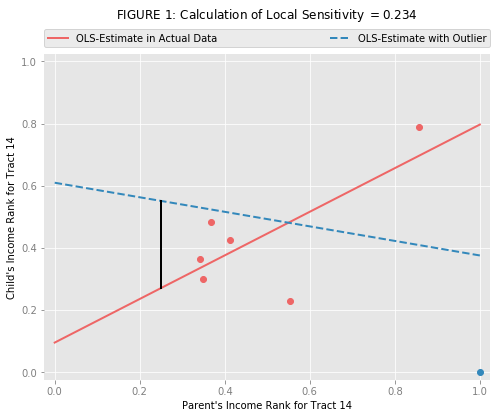

In [10]:
olsf1.plot()

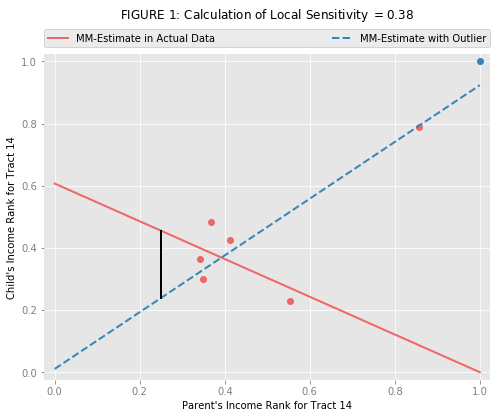

In [11]:
mmf1.plot()

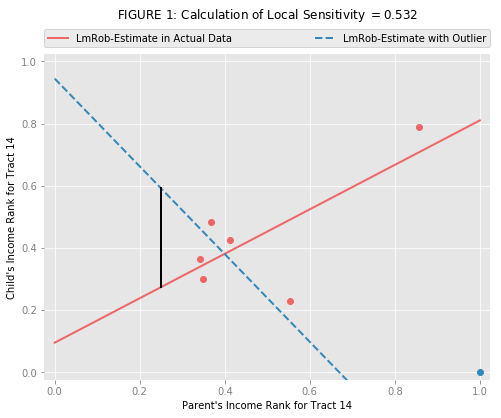

In [12]:
Rf1.plot()

[2] 
- compute the MOS envelope parameter $\chi$:

$$ \chi = \max_{cell}|\text{N}_{cell} \cdot \text{LS}_{cell}|$$

In [5]:
mmf2 = Alg_1(data, "MM", figure=["F2"])
olsf2 = Alg_1(data, "OLS", figure=["F2"])
Rf2 = Alg_1(data, "LmRob", figure=["F2"])

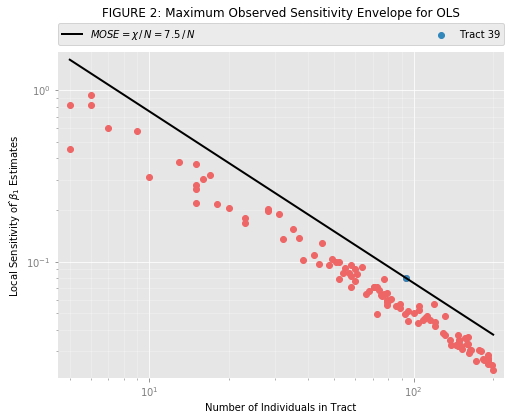

In [7]:
olsf2.plot()

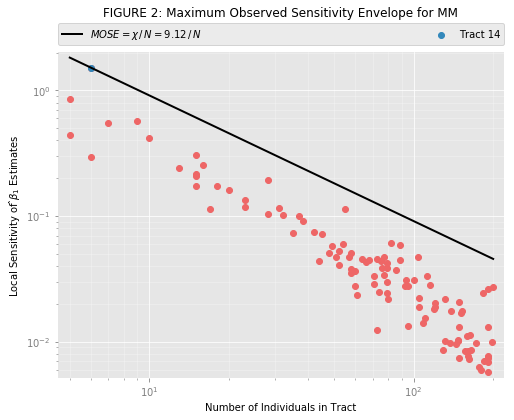

In [8]:
mmf2.plot()

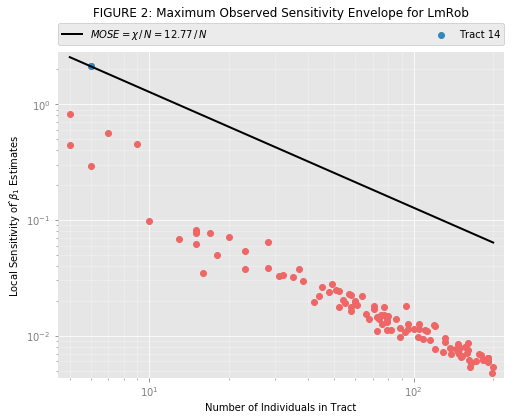

In [9]:
Rf2.plot()

[3] - Determine privacy parameter:

- n.b.: Chetty & Freidman use $\epsilon=4$ from comparing $\epsilon\in\{1,2,...,10\}$

[4] - Add random noise, $\omega \sim \text{Laplace}\left(0,\frac{1}{\sqrt{2}}\right)$:

$$ \tilde\beta_{cell} = \beta_{cell} + \sqrt{2}\frac{\chi}{\epsilon\cdot\text{N}_{cell}}\cdot\omega$$

- *repeat 4. for $\text{N}_{cell}$ and $\text{SE}\left(\tilde\beta_{cell}\right)$*
 
[5] - Release noise-infused statistics for groups of interest publicly

In [18]:
mm = Alg_1(data, "MM", figure=[])
ols = Alg_1(data, "OLS", figure=[])
Rf = Alg_1(data, "LmRob", figure=[])

mm1, mm2, mm3 = mm()
ols1, ols2, ols3 = ols()
R1, R2, R3 = Rf()

In [37]:
RR = np.asarray([ols.OLS(i) for i in range(111)])
B = RR.T[0]
BB = np.asarray([i[1] for i in B])

In [44]:
# Comparison of different Regression methods:
a = "OLS-Estimator: %s"%str(np.around(max(abs(ols1 - BB)), 4))
b = "MM-Estimator: %s"%str(np.around(max(abs(mm1 - BB)), 4))
c = "SMDM-Estimator: %s"%str(np.around(max(abs(R1 - BB)), 4))

In [53]:
print("Maximum absolute difference between true statistic by method")
print(a)
print(b)
print(c)

Maximum absolute difference between true statistic by method
OLS-Estimator: 0.24
MM-Estimator: 1.0616
SMDM-Estimator: 0.2673
